In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mettoolbox import mettoolbox as met
from tstoolbox import tstoolbox as ts

In [2]:
data_obs_hourly = pd.read_csv("data_obs_hourly.csv", index_col=0, parse_dates=True)
data_obs_daily = ts.read("data_obs_daily.csv")
plot_period = slice("2014-07-01", "2014-07-05")
longitude = 8.86
latitude = 51.00

In [3]:
jday = data_obs_daily.index.dayofyear.values
dec = 0.409 * np.sin(2.0 * np.pi * jday / 365.0 - 1.39)
lrad = latitude * np.pi / 180.0
s = np.arccos(-np.tan(dec) * np.tan(lrad))
data_obs_daily["ssd"] = 24.0 * s / np.pi

In [4]:
def hourly_rso(latitude=None, longitude=None, jday=None, jhour=None):
    """
    Calculate rso in MJ m-2 hour-1
    """
    # latitude = station.Latitude[0]
    # longitude = station.Longitude[0]
    # jday = temp_ts_hr.index.dayofyear.values
    # jhour = temp_ts_hr.index.hour.values
    # jdays=1.5
    # jday=np.floor(jdays)
    # jhour=(jdays-jday)*24
    # latitude=28.8025
    # longitude=-81.5
    # 'Roll-out' the distribution from day to day.
    # jday = np.arange(1, 367)

    # the solar declination
    dec = 0.409 * np.sin(2.0 * np.pi * jday / 365.0 - 1.39)
    # print(dec)
    lrad = latitude * np.pi / 180.0
    # print(lrad)
    # sunset hour angle
    s = np.arccos(-np.tan(dec) * np.tan(lrad))
    # t standard clock time at the midpoint of the period [hour]. For example for a period between 14.00 and 15.00 hours, t = 14.5,
    t = jhour + 0.5
    t1 = 1.0
    # Lz longitude of the centre of the local time zone [degrees west of Greenwich]. For example, Lz = 75, 90, 105 and 120° for the Eastern, Central, Rocky Mountain and Pacific time zones (United States)
    if abs(longitude) <= 7:
        Lz = 0.0
    elif (abs(longitude) > 7) & (abs(longitude) <= 23):
        Lz = 15.0
    elif (abs(longitude) > 23) & (abs(longitude) <= 37):
        Lz = 30.0
    elif (abs(longitude) > 37) & (abs(longitude) <= 53):
        Lz = 45.0
    elif (abs(longitude) > 53) & (abs(longitude) <= 67):
        Lz = 60.0
    elif (abs(longitude) > 67) & (abs(longitude) <= 83):
        Lz = 75.0
    elif (abs(longitude) > 83) & (abs(longitude) <= 97):
        Lz = 90.0
    elif (abs(longitude) > 97) & (abs(longitude) <= 113):
        Lz = 105.0
    elif (abs(longitude) > 113) & (abs(longitude) <= 127):
        Lz = 120.0

    # Lm longitude of the measurement site [degrees west of Greenwich],
    Lm = abs(longitude)
    b = 2 * np.pi * (jday - 81) / 364.0
    # Sc = The seasonal correction for solar time is
    Sc = 0.1645 * np.sin(2.0 * b) - 0.1255 * np.cos(b) - 0.025 * np.sin(b)
    # w is solar time angle at midpoint of the period
    w = np.pi / 12.0 * ((t + 0.0667 * (Lz - Lm) + Sc) - 12.0)
    # w1 is the solar time angle at the beginning of the period
    # w2 is the solar time angle at the end of the period
    w1 = w - (np.pi * t1 / 24.0)
    w2 = w + (np.pi * t1 / 24.0)
    # w1 and w2 should be within the range of -s to +s(daylight period) (-s is the sunrise hour angle)
    w1 = np.where((w1 < -s), -s, w1)
    w2 = np.where((w2 < -s), -s, w2)
    w1 = np.where((w1 > s), s, w1)
    w2 = np.where((w2 > s), s, w2)
    # inverse relative distance Earth-Sun
    dr = 1.0 + 0.033 * np.cos(2 * np.pi * jday / 365.0)
    # Ra is Extraterrestrial radiation for hourly or shorter periods --MJ m-2 hour-1
    # 59.04 is 12*60*Gsc  where Gsc=0.0820MJ m-2 min-1 (12 is used for hourly
    ra = (
        59.04
        / np.pi
        * dr
        * (
            (w2 - w1) * np.sin(lrad) * np.sin(dec)
            + np.cos(lrad) * np.cos(dec) * (np.sin(w2) - np.sin(w1))
        )
    )

    # N is Daylight hours
    N = 24.0 * s / np.pi
    a_s = 0.25  # recommended value
    b_s = 0.50  # recommended value
    rso = (a_s + b_s * (N / N)) * ra  # for near sea level

    return rso

In [5]:
# Potential hourly radiation
data_obs_hourly["Rso_MJm2/hr"] = hourly_rso(
    latitude=latitude,
    longitude=longitude,
    jday=data_obs_hourly.index.dayofyear.values,
    jhour=data_obs_hourly.index.hour.values,
)
data_obs_hourly["Rso_W/m2"] = data_obs_hourly["Rso_MJm2/hr"] / 0.0036
data_obs_hourly["Rso_W/m2"].to_csv("data_hourly_rad_pot.csv")

In [6]:
# data_obs_hourly[['precip','hum']].to_csv('data_obs_hourly_precip_hum.csv')
# data_obs_hourly['temp'].to_csv('data_obs_hourly_temp.csv')
# data_obs_hourly['glob'].to_csv('data_obs_hourly_glob.csv')

<b>Temperature<b>

sine_min_max
sine_mean
mean_course_mean
mean_course_min_max


Text(0, 0.5, 'Temperature [K]')

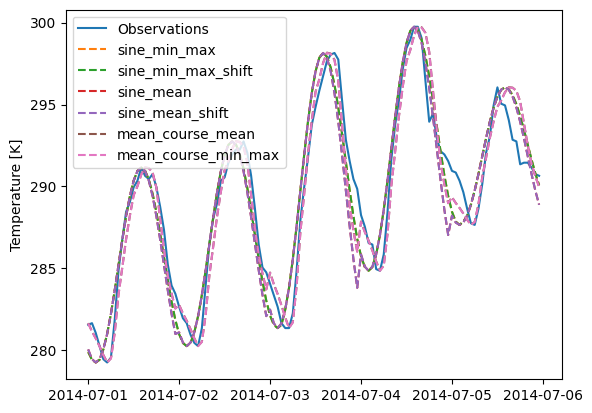

In [7]:
tempdf_mettoolbox = pd.DataFrame()
plt.plot(data_obs_hourly["temp"].loc[plot_period])
temp_methods = ["sine_min_max", "sine_mean", "mean_course_mean", "mean_course_min_max"]
for method in temp_methods:
    print(method)
    if method in ["sine_min_max", "sine_mean"]:
        tempdf_mettoolbox[method] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            min_max_time="sun_loc",
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
        tempdf_mettoolbox[method + "_shift"] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            min_max_time="sun_loc_shift",
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            hourly="data_obs_hourly_temp.csv",
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
    else:
        tempdf_mettoolbox[method] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            hourly="data_obs_hourly_temp.csv",
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
plt.legend(["Observations"] + list(tempdf_mettoolbox.columns))
plt.ylabel("Temperature [K]")

<b>Wind Speed<b>

equal
random
cosine


Text(0, 0.5, 'Wind speed [m/s]')

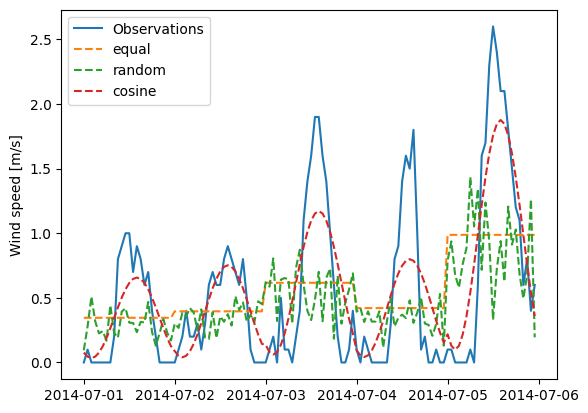

In [8]:
plt.plot(data_obs_hourly["wind"].loc[plot_period])
winddf_mettoolbox = pd.DataFrame()
wind_methods = ["equal", "random", "cosine"]
for method in wind_methods:
    print(method)
    winddf_mettoolbox[method] = met.disaggregate.wind_speed(
        input_ts=data_obs_daily,
        method=method,
        columns=9,
        a=0.9,
        b=1,
        t_shift=14.0,
        source_units=["m/s"],
    )
    plt.plot(winddf_mettoolbox[method].loc[plot_period], "--")


plt.legend(["Observations"] + wind_methods)
plt.ylabel("Wind speed [m/s]")

### Humidty

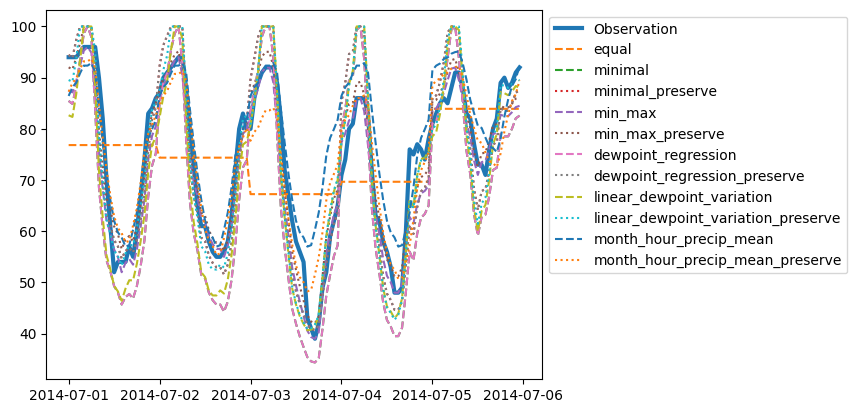

In [9]:
humiditydf_mettoolbox = pd.DataFrame()
humiditydf_mettoolbox["equal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="equal",
    hum_mean_col=6,
    source_units=["dimensionless"],
)
humiditydf_mettoolbox["minimal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["minimal_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["min_max"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=["dimensionless", "dimensionless", "dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["min_max_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=[
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
    ],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["dewpoint_regression"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
)
humiditydf_mettoolbox["dewpoint_regression_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["month_hour_precip_mean"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless"],
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
)
humiditydf_mettoolbox["month_hour_precip_mean_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
    preserve_daily_mean=6,
)


methods = humiditydf_mettoolbox.columns
plt.plot(data_obs_hourly["hum"].loc[plot_period], "-", linewidth=3)

for method in methods:
    if "preserve" in method:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], ":")
    else:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], "--")
plt.legend(["Observation"] + list(methods), bbox_to_anchor=(1, 1))

### Humidty

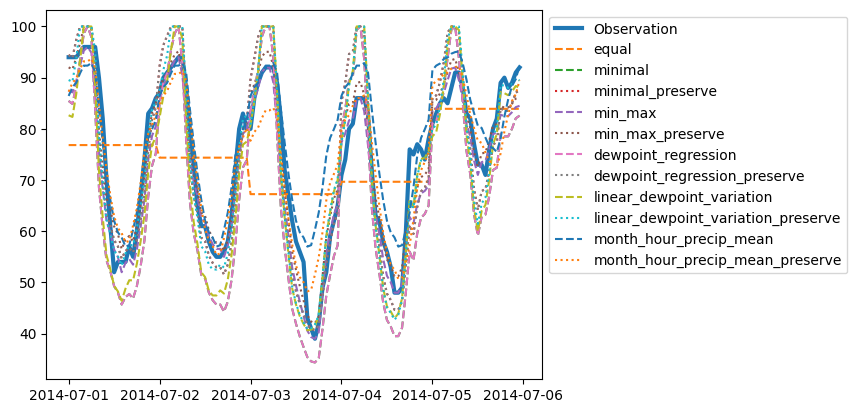

In [10]:
humiditydf_mettoolbox = pd.DataFrame()
humiditydf_mettoolbox["equal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="equal",
    hum_mean_col=6,
    source_units=["dimensionless"],
)
humiditydf_mettoolbox["minimal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["minimal_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["min_max"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=["dimensionless", "dimensionless", "dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["min_max_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=[
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
    ],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["dewpoint_regression"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
)
humiditydf_mettoolbox["dewpoint_regression_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["month_hour_precip_mean"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless"],
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
)
humiditydf_mettoolbox["month_hour_precip_mean_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
    preserve_daily_mean=6,
)


methods = humiditydf_mettoolbox.columns
plt.plot(data_obs_hourly["hum"].loc[plot_period], "-", linewidth=3)

for method in methods:
    if "preserve" in method:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], ":")
    else:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], "--")
plt.legend(["Observation"] + list(methods), bbox_to_anchor=(1, 1))

### Dew Point Temperature

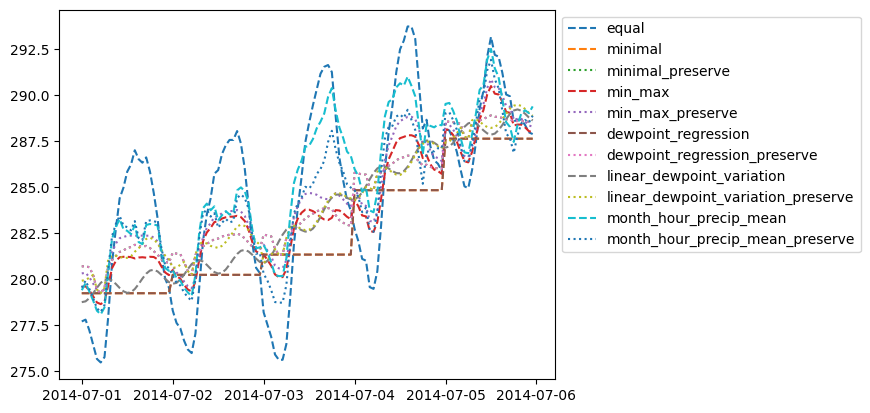

In [11]:
tdewdf_mettoolbox = pd.DataFrame()
tdewdf_mettoolbox["equal"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="equal",
    hum_mean_col=6,
    source_units=["degK"],
    hourly_temp="data_obs_hourly_temp.csv",
)
tdewdf_mettoolbox["minimal"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
)

tdewdf_mettoolbox["minimal_preserve"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)

tdewdf_mettoolbox["min_max"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=["degK", "degK", "degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
)
tdewdf_mettoolbox["min_max_preserve"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=["degK", "degK", "degK", "degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
tdewdf_mettoolbox["dewpoint_regression"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
)
tdewdf_mettoolbox[
    "dewpoint_regression_preserve"
] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    preserve_daily_mean=6,
)
tdewdf_mettoolbox["linear_dewpoint_variation"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
)
tdewdf_mettoolbox[
    "linear_dewpoint_variation_preserve"
] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
    preserve_daily_mean=6,
)

tdewdf_mettoolbox["month_hour_precip_mean"] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
)
tdewdf_mettoolbox[
    "month_hour_precip_mean_preserve"
] = met.disaggregate.dewpoint_temperature(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["degK", "degK"],
    hourly_temp="data_obs_hourly_temp.csv",
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
    preserve_daily_mean=6,
)


methods = tdewdf_mettoolbox.columns
# plt.plot(data_obs_hourly["hum"].loc[plot_period],'-',linewidth=3)

for method in methods:
    if "preserve" in method:
        plt.plot(tdewdf_mettoolbox[method].dropna().loc[plot_period], ":")
    else:
        plt.plot(tdewdf_mettoolbox[method].dropna().loc[plot_period], "--")
# plt.legend(['Observation']+list(methods),bbox_to_anchor=(1, 1))
plt.legend(list(methods), bbox_to_anchor=(1, 1))

### Radiation

In [12]:
radiationdf_mettoolbox = pd.DataFrame()
radiationdf_mettoolbox["mean_course"] = met.disaggregate.radiation(
    input_ts=data_obs_daily / 24,
    method="mean_course",
    glob_swr_col=5,
    source_units=["W/m**2"],
    hourly_rad="data_obs_hourly_glob.csv",
)
radiationdf_mettoolbox["pot_rad"] = met.disaggregate.radiation(
    input_ts=data_obs_daily / 24,
    method="pot_rad",
    glob_swr_col=5,
    source_units=["W/m**2"],
    lon=longitude,
    lat=latitude,
    pot_rad="data_hourly_rad_pot.csv",
)
radiationdf_mettoolbox["pot_rad_via_bc"] = met.disaggregate.radiation(
    input_ts=data_obs_daily,
    method="pot_rad_via_bc",
    temp_min_col=2,
    temp_max_col=3,
    bristcamp_a=0.75,
    bristcamp_c=4.4,
    source_units=["W/m**2", "W/m**2"],
    pot_rad="data_hourly_rad_pot.csv",
)
radiationdf_mettoolbox["pot_rad_via_ssd"] = met.disaggregate.radiation(
    input_ts=data_obs_daily,
    method="pot_rad_via_ssd",
    ssd_col=10,
    source_units=["W/m**2"],
    lon=longitude,
    lat=latitude,
    angstr_a=0.25,
    angstr_b=0.5,
    pot_rad="data_hourly_rad_pot.csv",
)

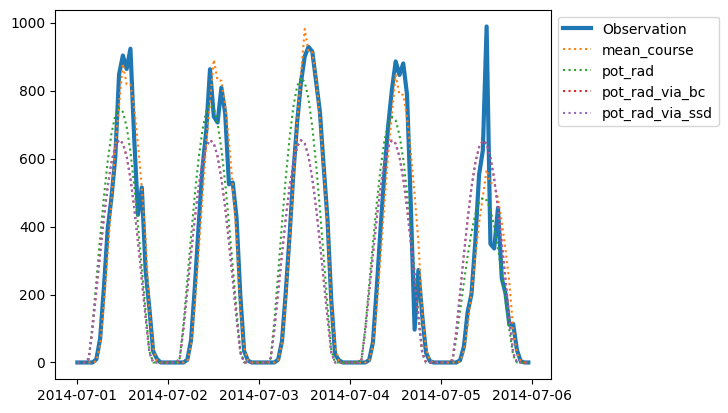

In [13]:
methods = radiationdf_mettoolbox.columns
plt.plot(data_obs_hourly["glob"].loc[plot_period], "-", linewidth=3)

for method in methods:
    plt.plot(radiationdf_mettoolbox[method].dropna().loc[plot_period], ":")
plt.legend(["Observation"] + list(methods), bbox_to_anchor=(1, 1))